# Imports

In [1]:
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model

# Models
from tensorflow.keras.layers import Input, Conv2D , MaxPool2D, Flatten, Dense , Dropout
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adagrad
from tensorflow.keras import regularizers

# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime

# Importing Data
from keras.preprocessing.image import ImageDataGenerator

## GPU Check

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Creating the Datasets

Define paramters for the data loaders

In [3]:
batch_size = 64  #4 Jaffe , 16 CK+ , 64 FER2013

validation_split = 0.3
img_height = 48
img_width = 48

learning_rate = 0.0001
print(learning_rate)

color_mode = 'grayscale'
dataset_name = "FER_2013" # "JAFFE" , "CK+" , "FER_2013"

train_data = "data/"+ dataset_name + "/train/"
test_data = "data/"+ dataset_name + "/test/"

print(train_data)
print(test_data)

0.0001
data/FER_2013/train/
data/FER_2013/test/


## Load the data into the datasets

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                    validation_split=validation_split,
                                    horizontal_flip=True)

train_ds=train_datagen.flow_from_directory(train_data,
                                            batch_size=batch_size,
                                            target_size=(img_height,img_width),
                                            shuffle=True,
                                            color_mode=color_mode,
                                            class_mode='categorical',
                                            subset='training'
                                           )

val_ds=train_datagen.flow_from_directory(train_data,
                                            batch_size=batch_size,
                                            target_size=(img_height,img_width),
                                            shuffle=True,
                                            color_mode=color_mode,
                                            class_mode='categorical',
                                            subset='validation'
                                           )



test_datagen = ImageDataGenerator(rescale=1./255)
test_ds = test_datagen.flow_from_directory(test_data,
                                            batch_size=batch_size,
                                            target_size=(img_height,img_width),
                                            shuffle=False,
                                            color_mode=color_mode,class_mode='categorical')

Found 20099 images belonging to 7 classes.
Found 8610 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## View the classes in the dataset

In [5]:
train_ds.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Creating the Model

In [6]:
import cnn_models
from cnn_models import *

architecture = "VGG"
model = "19"
attention = "" #SEnet , ECANet , CBAM
extra = ""

model_name = [architecture, model , attention , extra]
model_name = '_'.join(model_name)

#model = model_ResNet_V1(model="ResNet152", img_height=img_height , img_width=img_width,attention=attention , pooling="avg")
#model = model_ResNet_V2(model="ResNet50", img_height=img_height , img_width=img_width,attention=attention , pooling="avg")
model = model_vgg19(a_hidden="elu" , attention=attention)


## Compile the model

In [7]:
model.compile(optimizer = Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## View Model Summary

In [8]:
model.summary()

Model: "VGG19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 48, 48, 1)]       0         
                                                                 
 Conv1.1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 Conv1.2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 MaxPool2D_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 Conv2.1 (Conv2D)            (None, 24, 24, 128)       73856     
                                                                 
 Conv2.2 (Conv2D)            (None, 24, 24, 128)       147584    
                                                                 
 MaxPool2D_2 (MaxPooling2D)  (None, 12, 12, 128)       0     

## Plot the the CNN Model

In [9]:
# from tensorflow.keras.utils import plot_model
# from IPython.display import Image 


# plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
# Image('model.png', width = 400)

## Train the Model

In [10]:
name = [model_name, dataset_name , 'weights']
name = '_'.join(name) + ".hdf5"

checkpoint_file_path = "models/" + name


checkpoint = ModelCheckpoint(filepath=checkpoint_file_path,
                            monitor="val_accuracy",
                            verbose = 1,
                            save_best_only = True,
                            save_weights_only = False,
                            mode= "auto",
                            save_freq= "epoch",
                            options=None)


early_stop = EarlyStopping(monitor='val_loss',
                          min_delta=0, # Minimum change in the monitored quantity to qualify as an improvemen
                          patience=15, # Number of epochs with no improvement after which training will be stopped
                          verbose=1,
                          mode='auto')

# Load the TensorBoard notebook extension
log_dir = "logs/fit/" + model_name + "_" + dataset_name + datetime.datetime.now().strftime("%d-%H.%M.%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

## Execute Training 

In [11]:
epochs=200
history = model.fit(
    train_ds,
    workers=8,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = [early_stop,tensorboard_callback,checkpoint] 
)

Epoch 1/200
315/315 [==============================] - ETA: 0s - loss: 1.7100 - accuracy: 0.3076
Epoch 1: val_accuracy improved from -inf to 0.37851, saving model to models\VGG_19___FER_2013_weights.hdf5
315/315 [==============================] - 127s 384ms/step - loss: 1.7100 - accuracy: 0.3076 - val_loss: 1.5761 - val_accuracy: 0.3785
Epoch 2/200
315/315 [==============================] - ETA: 0s - loss: 1.5271 - accuracy: 0.4039
Epoch 2: val_accuracy improved from 0.37851 to 0.43089, saving model to models\VGG_19___FER_2013_weights.hdf5
315/315 [==============================] - 42s 133ms/step - loss: 1.5271 - accuracy: 0.4039 - val_loss: 1.4777 - val_accuracy: 0.4309
Epoch 3/200
315/315 [==============================] - ETA: 0s - loss: 1.4573 - accuracy: 0.4353
Epoch 3: val_accuracy improved from 0.43089 to 0.47166, saving model to models\VGG_19___FER_2013_weights.hdf5
315/315 [==============================] - 39s 123ms/step - loss: 1.4573 - accuracy: 0.4353 - val_loss: 1.3818 - 

Epoch 27/200
315/315 [==============================] - ETA: 0s - loss: 0.9385 - accuracy: 0.6520
Epoch 27: val_accuracy did not improve from 0.57120
315/315 [==============================] - 35s 110ms/step - loss: 0.9385 - accuracy: 0.6520 - val_loss: 1.1733 - val_accuracy: 0.5613
Epoch 28/200
315/315 [==============================] - ETA: 0s - loss: 0.9129 - accuracy: 0.6596
Epoch 28: val_accuracy improved from 0.57120 to 0.57282, saving model to models\VGG_19___FER_2013_weights.hdf5
315/315 [==============================] - 38s 119ms/step - loss: 0.9129 - accuracy: 0.6596 - val_loss: 1.1809 - val_accuracy: 0.5728
Epoch 29/200
315/315 [==============================] - ETA: 0s - loss: 0.8928 - accuracy: 0.6671
Epoch 29: val_accuracy did not improve from 0.57282
315/315 [==============================] - 36s 113ms/step - loss: 0.8928 - accuracy: 0.6671 - val_loss: 1.1901 - val_accuracy: 0.5633
Epoch 30/200
315/315 [==============================] - ETA: 0s - loss: 0.8781 - accuracy

## Accuracy and Loss Graphs

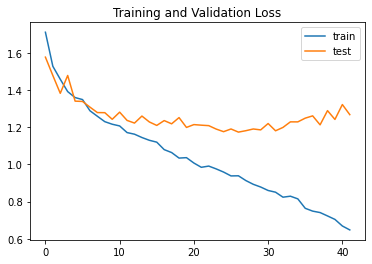

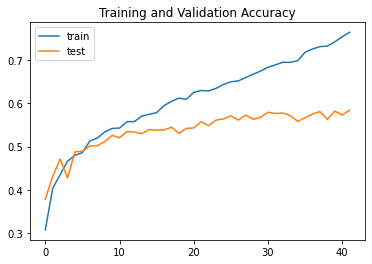

In [12]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(acc, label='train')
plt.plot(val_acc, label='test')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluate the Model

In [13]:
print("Evaluate")


#checkpoint_file_path_test = "models/" + "VGG_19___FER_2013_weights.hdf5"



model.load_weights(checkpoint_file_path) #Load the best weights from the file
result = model.evaluate(test_ds)
dict(zip(model.metrics_names, result))

Evaluate
113/113 [==============================] - 30s 266ms/step - loss: 1.2072 - accuracy: 0.6209


{'loss': 1.207199215888977, 'accuracy': 0.6209250688552856}

In [14]:
import winsound

winsound.Beep(300, 700)

## Confusion Matrix and Classification

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
              precision    recall  f1-score   support

       angry     0.5537    0.5219    0.5373       958
     disgust     0.7969    0.4595    0.5829       111
        fear     0.4657    0.4580    0.4618      1024
       happy     0.7907    0.8478    0.8183      1774
     neutral     0.5363    0.6058    0.5689      1233
         sad     0.5171    0.4844    0.5002      1247
    surprise     0.7854    0.7004    0.7405       831

    accuracy                         0.6209      7178
   macro avg     0.6351    0.5825    0.6014      7178
weighted avg     0.6210    0.6209    0.6192      7178



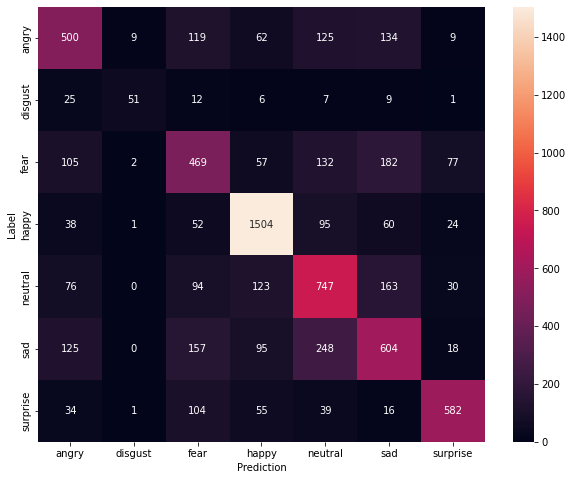

In [15]:
import seaborn as sns
from sklearn.metrics import classification_report

# defines which dataset we want to show the confusion matrix and classification report 
dataset = test_ds



# Get predictions from the model
predictions = model.predict(dataset)
predictions = np.argmax(predictions, axis=1)

class_labels = []
for c in dataset.class_indices:
    class_labels.append(c)

print(class_labels)

# create a confusion matrix
confusion_mtx = tf.math.confusion_matrix(dataset.classes, predictions , num_classes=7)

# Function that displays the confusion matrix
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=class_labels, yticklabels=class_labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()


print(classification_report(dataset.classes, predictions, target_names=class_labels , digits=4))
show_confusion_matrix(confusion_mtx, class_labels)
